In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set_context('talk')
np.set_printoptions(suppress=True) 
    ### not xEyy format(science float format)
%matplotlib inline    

In [2]:
import scipy.io
data = scipy.io.loadmat('ex3data1.mat')

X = data['X']
y = data['y']

In [3]:
def displayData(X, ex_width=0, fig_size=4):
    m, n = X.shape
    if ex_width == 0:
        ex_width = int(math.sqrt(n))
    ex_height = n/ex_width
    rows = int(math.sqrt(m))
    cols = int(m/rows)
    pad = 2
    
    display_arr = -np.ones([pad + rows * (ex_width + pad),
                       pad + cols * (ex_height + pad)])

    idx = 0
    for i in range(rows):
        for j in range(cols):
            max_val = np.max(np.abs(X[idx]))
            display_arr[
                (pad + i*(ex_width+pad)) : ((i+1)*(ex_width+pad)), 
                (pad + j*(ex_height+pad)) : ((j+1)*(ex_height+pad))
            ] = X[idx].reshape(ex_height, ex_width).T/max_val
            idx += 1

    plt.figure(figsize=(fig_size,fig_size));
    plt.imshow(display_arr, cmap='gray');

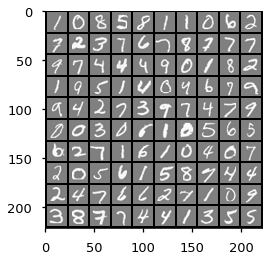

In [4]:
rand_indices = np.random.permutation(len(X))[:100]
display_x = X[rand_indices]
displayData(display_x)

In [5]:
data = scipy.io.loadmat('ex3weights.mat')
Theta1 = data['Theta1']
Theta2 = data['Theta2']
print X.shape
print Theta1.shape
print Theta2.shape

(5000L, 400L)
(25L, 401L)
(10L, 26L)


In [6]:
nn_params = np.append(Theta1.flatten(order='F'), 
                      Theta2.flatten(order='F')) ### like matlib order
nn_params.shape = (-1,1)
nn_params.shape

(10285L, 1L)

In [7]:
def reshapeTheta(nn_params1, input_layer_size,
                hidden_layer_size, num_labels):
    theta01_n = hidden_layer_size *(input_layer_size+1)
    theta01 = nn_params1[:theta01_n].reshape(
            hidden_layer_size, input_layer_size+1, order='F')
    theta02 = nn_params1[theta01_n:].reshape(
            num_labels, hidden_layer_size+1, order='F')
    return theta01, theta02

In [8]:
def sigmoid(z):
    return (1.0/(1.0+np.exp(-z)))

def sigmoidGradient(z):
    g = sigmoid(z) * (1.0-sigmoid(z))
    return g

def expandY(y, num_labels):
    yy = np.zeros([len(y), num_labels])
    for i in xrange(len(y)):
        j = y[i] -1
        yy[i, j] = 1
    return yy

def nnCostJ(nn_params, *args):
    (input_layer_size, 
     hidden_layer_size,
     num_labels,
     X, y, lamb) = args
    nn_params = nn_params.reshape(-1,1)
    
    theta1, theta2 = reshapeTheta(nn_params, input_layer_size,
                                 hidden_layer_size, num_labels)
    m  = len(X)
    X  = np.append(np.ones([m, 1]), X, axis=1)
    Z2 = np.dot(X, theta1.T)
    A2 = sigmoid(Z2)
    A2 = np.append(np.ones([m, 1]), A2, axis=1)
    Z3 = np.dot(A2, theta2.T)
    A3 = sigmoid(Z3)
    hx = A3
    y = expandY(y, num_labels)
    J1 = -y * np.log(hx)
    J2 = (1.0 - y) * np.log(1.0 - hx)
    J = 1.0/m * np.sum(J1-J2)
    
    theta1_but0 = theta1[:, 1:]
    theta2_but0 = theta2[:, 1:]
    J3 = lamb/(2.0*m) * (
        np.sum(theta1_but0**2) + np.sum(theta2_but0**2))
    J = J+J3
    return J

def nnCostGrad(nn_params, *args):
    (input_layer_size, 
     hidden_layer_size,
     num_labels,
     X, y, lamb) = args
    nn_params = nn_params.reshape(-1,1)
    
    theta1, theta2 = reshapeTheta(nn_params, input_layer_size,
                                 hidden_layer_size, num_labels)
    theta1_grad = np.zeros(theta1.size)
    theta2_grad = np.zeros(theta2.size)
    
    m  = len(X)
    X = np.append(np.ones([m, 1]), X, axis=1)
    Z2 = np.dot(X, theta1.T)
    A2 = sigmoid(Z2)
    A2 = np.append(np.ones([m, 1]), A2, axis=1)
    Z3 = np.dot(A2, theta2.T)
    A3 = sigmoid(Z3)
    y = expandY(y, num_labels)
    
    delta3 = A3-y
    theta2_but0 = theta2[:, 1:]
    delta2 = np.dot(delta3, theta2_but0) * sigmoidGradient(Z2)
    theta1_copy = theta1.copy()
    theta2_copy = theta2.copy()
    theta1_copy[:, 0] = 0
    theta2_copy[:, 0] = 0
    theta1_grad = 1.0/m * np.dot(delta2.T, X) + lamb/m*theta1_copy
    theta2_grad = 1.0/m * np.dot(delta3.T, A2)+ lamb/m*theta2_copy
    
    ## unroll gradients
    grad = np.append(theta1_grad.flatten(order='F'),  ### matlab order
                     theta2_grad.flatten(order='F')
                    )
    return grad

In [9]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
theta1, theta2 = reshapeTheta(nn_params, input_layer_size,
                             hidden_layer_size, num_labels)
print theta1.shape
print theta2.shape
print (theta1==Theta1).astype(int).prod().astype(bool)
print (theta2==Theta2).astype(int).prod().astype(bool)

(25L, 401L)
(10L, 26L)
True
True


In [10]:
def nnCostFunction(nn_params, input_layer_size,
                  hidden_layer_size, num_labels,
                  X, y, lamb):
    J = nnCostJ(nn_params, input_layer_size, hidden_layer_size,
               num_labels, X, y, lamb)
    grad = nnCostGrad(nn_params, input_layer_size, hidden_layer_size,
                     num_labels, X, y, lamb)
    grad = grad.reshape(-1, 1)
    return J, grad

In [11]:
lamb = 0.0
J, grad = nnCostFunction(nn_params, input_layer_size, 
                         hidden_layer_size, num_labels,
                         X, y, lamb)
print J   ### 0.287629

0.2876291651613189


In [12]:
lamb = 1.0
J, grad = nnCostFunction(nn_params, input_layer_size,
                        hidden_layer_size, num_labels,
                        X, y, lamb)
print J   ### 0.383770

0.38376985909092365


In [13]:
g = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))
print g.round(6)

[0.196612 0.235004 0.25     0.235004 0.196612]


In [14]:
def randInitializeWeights(L_in, L_out):
    eps = 0.12
    return np.random.rand(L_out, L_in+1)*2*eps-eps

In [15]:
def debugInitializeWeights(fan_out, fan_in):
    w = np.zeros([fan_out, fan_in +1])
    w = np.sin(np.arange(1, w.size+1)).reshape(w.shape, order='F')
    w = w/10
    return w

In [16]:
def computeNumericalGradient(Jfunc, theta, *args):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    for p in xrange(theta.size):
        perturb[p] = e
        loss1 = Jfunc(theta-perturb, *args)
        loss2 = Jfunc(theta+perturb, *args)
        numgrad[p] = (loss2-loss1)/(2*e)
        perturb[p] = 0
    return numgrad

In [17]:
def checkNNGradients(lamb=0.0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    theta1 = debugInitializeWeights(
        hidden_layer_size, input_layer_size)
    theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    X = debugInitializeWeights(m, input_layer_size-1)
    y = 1 + np.arange(1, m+1)%num_labels
    y = y.reshape(-1,1)
    
    nn_params = np.append(theta1.flatten(order='F'),
                          theta2.flatten(order='F'),
                         ).reshape(-1,1)
    numgrad = computeNumericalGradient(nnCostJ, nn_params,
                         input_layer_size, hidden_layer_size,
                         num_labels, X, y, lamb)
    cost, grad = nnCostFunction(nn_params,
                               input_layer_size, hidden_layer_size,
                               num_labels, X, y, lamb)
#     print np.append(numgrad, grad, axis=1)
    diff =  np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print 
    print 'If your backpropagation implementation is correct.'
    print 'The relative difference will be small, less than 1e-9'
    print 'Relative Difference:', diff

In [18]:
checkNNGradients()


If your backpropagation implementation is correct.
The relative difference will be small, less than 1e-9
Relative Difference: 2.3472600933075295e-11


In [19]:
checkNNGradients(3.0)


If your backpropagation implementation is correct.
The relative difference will be small, less than 1e-9
Relative Difference: 2.2354642678996854e-11


### Training NN
- - -

In [20]:
import scipy.optimize as opt
def fmincg(nn_params, input_layer_size, 
                      hidden_layer_size,
                      num_labels,
                      X, y, lamb):
    ncg = opt.fmin_cg(nnCostJ, nn_params, fprime=nnCostGrad,
                      maxiter = 50,
                    args=(input_layer_size, 
                         hidden_layer_size,
                         num_labels,
                         X, y, lamb), 
                    full_output=True, disp=True)
    return ncg[0], ncg[1]

In [21]:
init_Theta1 = randInitializeWeights(input_layer_size,
                                   hidden_layer_size)
init_Theta2 = randInitializeWeights(hidden_layer_size,
                                   num_labels)
init_nn_params = np.append(init_Theta1.flatten(order='F'),
                           init_Theta2.flatten(order='F'),
                          ).reshape(-1,1)

In [22]:
lamb = 1.0
nn_params_final, costJ = fmincg(init_nn_params, input_layer_size,
                         hidden_layer_size, num_labels,
                         X, y, lamb)

         Current function value: 0.468495
         Iterations: 50
         Function evaluations: 109
         Gradient evaluations: 109


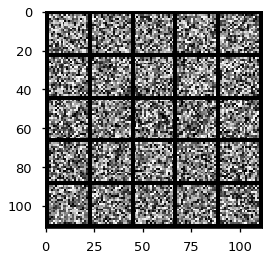

In [23]:
theta11, theta22 = reshapeTheta(init_nn_params, input_layer_size,
                              hidden_layer_size, num_labels)
displayData(theta11[:, 1:])

In [24]:
def predict(theta1, theta2, X):
    m = len(X)
    p = np.zeros([m,1])
    
    X = np.append(np.ones([m,1]), X, axis=1)
    Z2 = np.dot(X, theta1.T)
    A2 = sigmoid(Z2)
    
    A2 = np.append(np.ones([m,1]), A2, axis=1)
    Z3 = np.dot(A2, theta2.T)
    A3 = sigmoid(Z3)
    
    for i in xrange(m):
        k = A3[i].argmax() + 1
        p[i] = k
        
    return p

In [25]:
pred = predict(theta1, theta2, X)
print 'Training Set Accuracy: %.2f%%'%(
    np.mean((pred==y).astype(int)*100.0))

Training Set Accuracy: 97.52%
